In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import poisson
from joblib import Parallel, delayed
import time
import sys
from scipy.optimize import minimize, Bounds, LinearConstraint, minimize_scalar

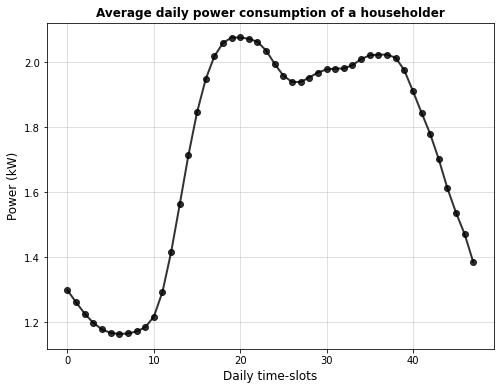

In [3]:
# Import the load profile
load_curve = np.loadtxt('data/load_agg_data.csv', delimiter=',', skiprows=1)[:, 2] * 4.1
plt.figure(figsize=(8,6))
plt.plot(load_curve, '-o', lw=2, c='black', alpha=0.8)
plt.title('Average daily power consumption of a householder', size=12, fontweight='bold')
plt.xlabel('Daily time-slots', size=12)
plt.ylabel('Power (kW)', size=12)
plt.grid(alpha=0.5);

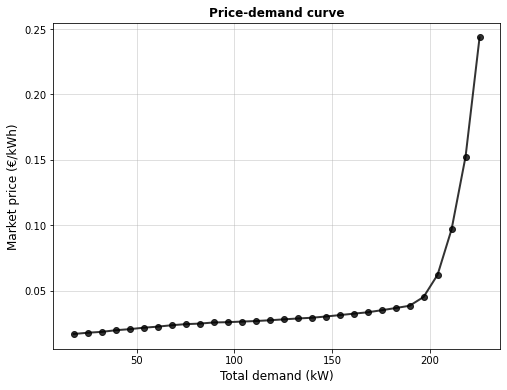

In [27]:
# Import market price (MW, Euro/MWh)
from scipy.interpolate import interp1d
market_price_data = np.loadtxt('data/market_price_UK.csv', delimiter=',')

# rescaling of the total demand to fit the simulation
tot_demand = market_price_data[:, 0] * 100 - 210

market_price = interp1d(tot_demand, market_price_data[:, 1] / 1000, kind='cubic')
x = np.linspace(tot_demand[0], tot_demand[-1], 30)
plt.figure(figsize=(8,6))
plt.plot(x, market_price(x), '-o', lw=2, c='black', alpha=0.8)
plt.xlabel('Total demand (kW)', size=12)
plt.ylabel('Market price (€/kWh)', size=12)
plt.title('Price-demand curve', size=12, fontweight='bold')
plt.grid(alpha=0.5)

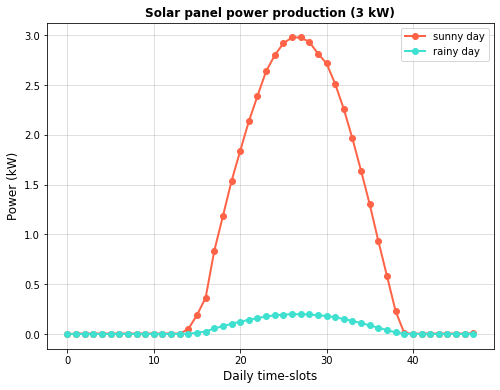

In [17]:
# import photovoltaic system power profiles
s = pd.read_csv('data/panel_power.csv', delimiter=',', usecols=[1,2,3,4])
plt.figure(figsize=(8,6))
plt.xlabel('Daily time-slots', size=12)
plt.ylabel('Power (kW)', size=12)
plt.title('Solar panel power production (3 kW)', size=12, fontweight='bold')
plt.plot(s.time*2, s.sunny, '-o', c='tomato', lw=2, label='sunny day')
plt.plot(s.time*2, s.rainy, '-o', c='turquoise', lw=2, label='rainy day')
plt.legend();
plt.grid(alpha=0.5)

### Functions

In [28]:
# Customer's utility function: for optimizing wrt b_pm
def u(b_pm, p, l, s):
    """
    b_pm: charging profile (1x2T)
    p: price vector (1xT)
    b_m: discharging profile (1xT)
    l: load profile (1xT)
    c: running cost of storage
    s: power supply from energy generators 
    
    """
    return np.sum(p * (b_pm[:T] - alpha * b_pm[T:] + l - s))

def constr_matrix_b(alpha):
    """
    alpha: efficiency
    """
    # storage efficiency
    mat1 = np.zeros(shape=(1, 2*T), dtype='float')
    for j in range(T):
        mat1[0, j] = -1
        mat1[0, j+T] = 1

    # within charging and discharging capacity
    mat2 = np.hstack([np.identity(T, dtype='float'), np.zeros(shape=(T, T), dtype='float')])
    mat3 = np.hstack([np.zeros(shape=(T, T), dtype='float'), np.identity(T, dtype='float')])

    # energy that can be stored or used at a time slot
    mat4 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat4[i, :i] = -1
        mat4[i, T:T+i] = 1
    for i in range(T):
        mat4[i, T+i] = 1

    mat5 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat5[i, :i] = 1
        mat5[i, T:T+i] = -1
    for i in range(T):
        mat5[i, i] = 1    

    return np.vstack([mat1, mat2, mat3, mat4, mat5])

def constr_vectors_b(b_sup, b_inf, alpha, e0, e, l):
    """
    n: customer's index
    """
    # left
    leftv1 = np.zeros(1)          # bilateral
    leftv2 = np.zeros(T)          # bilateral
    leftv3 = np.zeros(T)          # bilateral
    leftv4 = -np.ones(T)*np.inf   # unilateral
    leftv5 = -np.ones(T)*np.inf   # unilateral
    leftv_constr = np.concatenate([leftv1, leftv2, leftv3, leftv4, leftv5])

    # right
    rightv_constr = np.concatenate([[0], [b_sup] * T, [b_inf] * T, [e0] * T, [e - e0] * T])
    return leftv_constr, rightv_constr

def optimize_b(f, b_sup, b_inf, p, alpha, e0, e, l, x0, s):
    mat_constr = constr_matrix_b(alpha)
    leftv_constr, rightv_constr = constr_vectors_b(b_sup, b_inf, alpha, e0, e, l)
    linear_constraint = LinearConstraint(mat_constr, leftv_constr, rightv_constr)
    bounds = Bounds([0] * 2 * T, [max(b_sup, b_inf)] * 2 * T)
    b_opt = minimize(f, x0, args=(p, l, s), method='trust-constr',
        constraints=linear_constraint,
        bounds=bounds,
        options={'verbose' : 0})
    return b_opt.x

### Parameters

In [41]:
n_nodes = 100   # total number of consumers
n_smart = 30    # consumers with storage and renewable energy
T = 48          # number of time slots in a day(1 slot = 0.5 hours)
n_days = 100     # number of days to simulate 
beta = 0.05     # storage profile learning rate
b_inf = 0.2     # maximum discharge in a time slot (kWh)
b_sup = 0.2     # maximum charge in a time slot(kWh)
alpha = 0.8     # efficiency
e = 5.          # storage capacity
sigma = 0.05

weather = ['sunny'] * n_days
rain_indices = [8, 9, 10, 16, 17, 25, 26, 27, 28, 36, 37, 45, 46, 47, 55, 56, 60,
               70, 71, 72, 73, 74, 89, 90, 91]
for i in rain_indices:
    weather[i] = 'rainy'

l = np.ndarray(shape=(0, T))
for i in range(n_nodes):
    l = np.append(l, [load_curve_tot[i:i+T]], axis=0)

In [42]:
# import best-response profles
br_b_sun = np.load('Results/b_history-sunny-100d.npy')[-1]
br_b_rain = np.load('Results/b_history-rainy-50d.npy')[-1]
br_b = pd.DataFrame({'sunny' : br_b_sun, 'rainy' : br_b_rain})

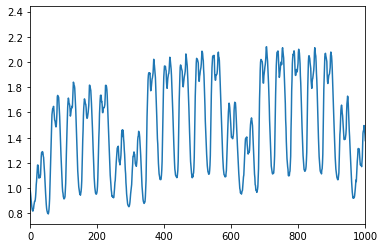

In [34]:
# import load profiles
load_curve_tot = np.load('data/load_agg_real.npy')
plt.plot(load_curve_tot)
plt.xlim(0,1000);

# Aware

In [43]:
# Intialization
e0 = np.zeros(n_smart)                                            # storage level
b_pm = np.zeros(shape=(n_smart, 2*T))                             # charging profiles
b_history = np.ndarray(shape=(0, T))                              # storage profile history
p_history = np.ndarray(shape=(0, T))                              # price history

p = market_price(l.sum(axis=0) - alpha * b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
p_history = np.append(p_history, [p], axis=0)
u_history = np.ndarray(shape=(0, n_smart))
x0 = np.zeros(shape=(n_smart, 2*T))
l_day = np.zeros(shape=(n_nodes, T))        # load profiles

In [44]:
for d in range(n_days):
    t_start = time.time()
    for i in range(n_nodes):
        l_day[i, :] = l[i,(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

    p = market_price(l_day.sum(axis=0) + n_smart * br_b[weather[d]] - n_smart * s[weather[d]])
    p_history = np.append(p_history, [p], axis=0)
    u_history = np.append(u_history, [[np.sum(p*(l_day[n, :] + br_b[weather[d]] - s[weather[d]])) for n in range(n_smart)]], axis=0)

In [45]:
# alpha is not there

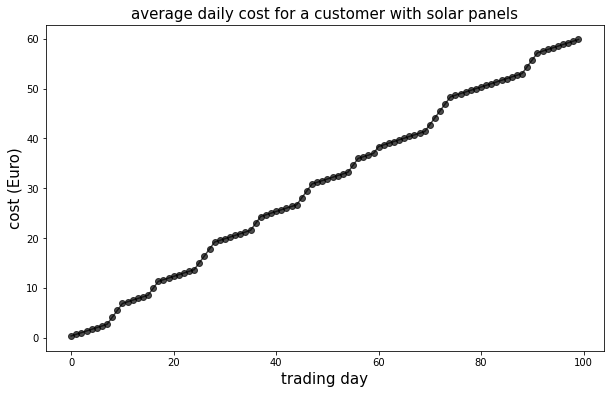

In [47]:
plt.figure(figsize=(10,6))
plt.title('average daily cost for a customer with solar panels', size=15)
plt.xlabel('trading day', size=15)
plt.ylabel('cost (Euro)', size=15)
plt.plot(u_history.mean(axis=1).cumsum(), '-o', c='black', alpha=0.7);

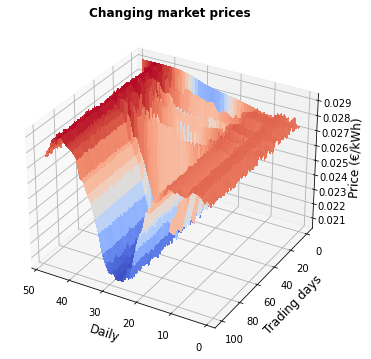

In [39]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6))
X = np.arange(1, T+1, 1)
Y = np.arange(0, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, p_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=12)
ax.set_xlabel('Daily', size=12)
ax.set_zlabel('Price (€/kWh)', size=12)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
ax.set_title('Changing market prices', size=12, fontweight='bold');

(104, 48)